This notebook requires the following Python packages which can be installed using `pip`:

* `keras`

* `opencv-python`

* `numpy`

* `matplotlib`

* `ipywidgets`

Enable interactive plots by running `jupyter nbextension enable --py widgetsnbextension` 

There are interactive plots which can be generated by running the notebook.  Lines which train the models have been commented out so the notebook should only take a couple minutes to run.  If the interactive plots do not work, I have added some `.gif`s to illustrate the same figures.

For my final project I wanted to try to solve a niche problem that I have encountered in my experiences of competitive jump rope.  There are two types of jump rope events that are done at competitions: freestyle and speed.  Freestyle is certainly the more exciting of the two and involves performing as many difficult and diverse skills as possible in a certain time window as shown in the clip below:

In [13]:
%%HTML
<video width="640" height="360" controls>
  <source src="writeup_videos/summit_routine.mp4" type="video/mp4">
</video>

Speed involves trying to jump the rope as many times as possible in either 30 seconds or 3 minutes.  Jumpers have adapted a jogging step motion to maximize speed as it minimizes the amount of time that your feet are off the ground.  This has rapidly increased speed scores to the point that human judges became unable to count every single jump.  The compromise has been to have four judges count only the right foot of the jumper and then average the doubled count from each judge.  Athletes have continued to increase in speed however, and even this one-foot counting is becoming impossible for human judges as can be seen in the video below of a previous world record in the 30 second event (note the score of 108 is right foot only and the final score is actually 216, try to count yourself, it's pretty difficult even for an experienced jumper!):

In [14]:
%%HTML
<video width="640" height="360" controls>
  <source src="writeup_videos/cen_30s.mp4" type="video/mp4">
</video>

This leads to the question of can an algorithm out-perform human judges in counting speed from video?  I will attempt to build a neural network approach to solve this problem.

Thankfully I have been involved in this sport for over a decade and I have a collection of videos of speed jumping that I can play in slow motion and count each jump (note: I will be training this model to count *both* feet) to label the data which will be fed into the neural network.

I wrote the `label_videos.py` script to create the dataset that will be used to train the model.  It reads any video files in the `unlabeled_videos/` directory and plays them at 10fps listening for an `s` key tap on each jump.  It will save a `numpy` array containing the frame numbers of each jump.

I labeled 15 videos for a total of 14,415 frames.

The first decision we have to make is to decide how to represent the problem.  I opted to represent the problem as a multi-class classification problem where each speed video is split into a $k$-frame window and the output of the neural network is a vector of values between 0 and 1 indicating whether a jump occured at that particular frame.

Let's take a look at what this looks like by using a window of 4 frames.  I will continue using a window of 4 frames for reason that will become clear later:

In [15]:
import os

data_dir = os.getcwd() + '/data/'
video_dir = 'speed_videos/'
annotation_dir = 'speed_annotations/'

frame_size = 128
window_size = 4
use_flow_field = False
grayscale = True

In [16]:
import cv2
import numpy as np

def open_video(file, window_size, flow_field=False):
    cap = cv2.VideoCapture(file)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = frame_size
    frameHeight = frame_size

    if grayscale:
        buf = np.zeros((frameCount, frameHeight, frameWidth), dtype=np.uint8)
    else:
        buf = np.zeros((frameCount, frameHeight, frameWidth, 3))

    fc = 0
    ret = 1

    while True:
        try:
            ret, img = cap.read()
            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (frame_size, frame_size), interpolation=cv2.INTER_AREA)
            buf[fc] = img.copy()
            fc += 1
        except Exception as e:
            break
    cap.release()
    if grayscale:
        buf = np.reshape(buf, (frameCount, frameHeight, frameWidth, 1))
    return buf

In [111]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
import matplotlib.pyplot as plt
    
def plot_frame(clip, label, save_frames=False):
    def f(i):
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(121)
        ax.set_xticks([])
        ax.set_yticks([])
        save_dir = ''
        if use_flow_field:
            flow = flow_to_rgb(clip[i, ...])
            ax.imshow(flow)
            save_dir = 'flow'
        elif grayscale:
            ax.imshow(clip[i, ..., 0], cmap='gray')
            save_dir = 'grayscale'
        else:
            ax.imshow(clip[i, ..., 0], cmap='gray')
            save_dir = 'rgb'
        
        ax = plt.subplot(122)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.plot(np.arange(window_size), label)
        ax.scatter(i, label[i], c='r')
        if save_frames:
            fig.savefig('conv_vis/' + save_dir + '/%d.png' % i)
        plt.show()
    return f

In [19]:
def flow_to_rgb(flow):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3))
    hsv[..., 1] = 255
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(np.uint8(hsv), cv2.COLOR_HSV2RGB)

In [20]:
video_path = 'hiro_2.mp4'

#get a single vector field from two frames of the video
def get_flow_field(video, i, j):
    prev = cv2.cvtColor(video[i], cv2.COLOR_BGR2GRAY)
    next = cv2.cvtColor(video[j], cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

# convert video to sequence of vector fields representing optical flow over time
def video_to_flow_field(video):
    flow = np.array([])
    for i in range(len(video) - 1):
        field = get_flow_field(video, i, i + 1)
        flow = np.append(flow, field)
    return np.reshape(flow, (video.shape[0] - 1, video.shape[1], video.shape[2], 2))


def get_clip_and_label(video_path):
    video = open_video(data_dir + video_dir + video_path, window_size=window_size)
    label_path = data_dir + annotation_dir + video_path.replace('.mp4', '.npy')
    label = np.load(label_path)
    start_frame = np.random.randint(0, len(video) - window_size)
    clip = video[start_frame:start_frame + window_size]
    if use_flow_field:
        flow_field = video_to_flow_field(np.uint8(clip))
        label_clip = label[np.where(label < start_frame + window_size - 1)]
        label_clip = label_clip[np.where(label_clip > start_frame)]
        y = np.zeros(window_size - 1)
    else:
        label_clip = label[np.where(label < start_frame + window_size)]
        label_clip = label_clip[np.where(label_clip > start_frame)]
    y = np.zeros(window_size)
    for frame in label_clip:
        y[frame - start_frame] = 1
    if use_flow_field:
        return flow_field, y
    else:
        return clip, y

clip, y = get_clip_and_label(video_path)
if use_flow_field:
    interactive_plot = interactive(plot_frame(clip, y), i=(0, window_size - 2))
else:
    interactive_plot = interactive(plot_frame(clip, y), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '360px'
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='360px'))), _dom…

Move the slider in the figure above to view different frames of the 4 frame clip.  The label has been converted to a one-hot representation where 1 corresponds to a jump on that particular frame and is shown in the plot on the right.

Now that we have a representation for the problem, we should try a few approaches to training our model on the data.  The approaches that I will try involve training the model on the full RGB video frames, grayscale frames, and a motion vector field computed using the Lucas-Kanade optical flow algorithm (https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method)

The model will consist of stacked 3D convolutions where each kernel is convolved over both the spatial dimensions of the frames but also the time dimension of the video.  The goal of this is to learn spatio-temporal features of jumps which will then be used to classify the frames as either containing a jump or not.

A summary of the model architecture is shown below.  The video clip is fed into a sequence of 3D convolution layers and the final feature vector is flattened and mapped to the four binary output values.  Not shown are pooling layers after each convolution layer

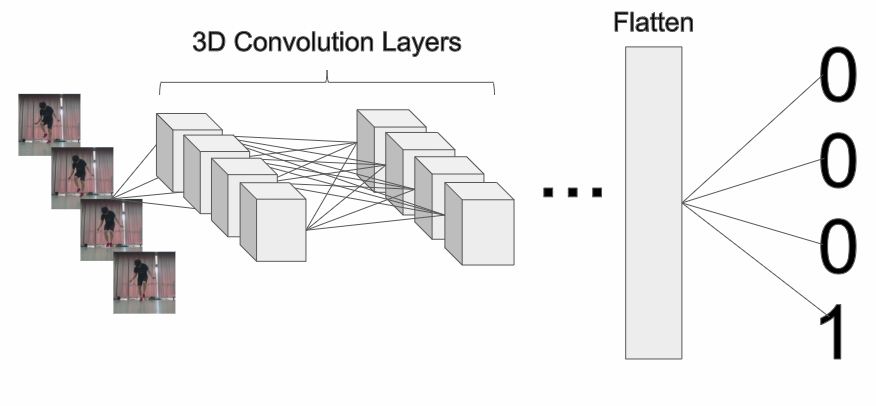

In [72]:
from IPython.display import Image
Image(filename='figures/model_architecture.png', width=438, height=203) 

The 3D convolution layers are identical to time distributed 2D convolutions.  Here is an intuitive animation of what a 3D convolution looks like when applied to a 3D input such as a video where we consider the 3rd dimension of the data to be time (https://thomelane.github.io/convolutions/3DConv.html):

In [1]:
%%HTML
<img src="figures/3d_convolution.gif" width="438" height="203" />

The reason that a 4 frame window was selected is so the problem can be framed as categorical classification.  At world record level speed (currently 226 jumps in 30 seconds by Cen Xiaolin) jumpers complete ~7.5 jumps per second.  Assuming that the videos we are using are 30fps, we can compute the maximum number of frames we can use and be certain that only one jump will occur in that window:

$$frames = \frac{1}{\frac{7.5 jumps}{1 second} \frac{1 second}{30 frames}} = 4$$

Meaning we should use a window size of 4 so that our one-hot labels only ever have a single `1`.

We will train the model using Keras' built-in `categorical_crossentropy` loss function which is defined as:

$$ -\frac{1}{k}\sum_{i=1}^k \sum_{c=1}^k I_c(y_i) log \hat{y_i} $$

Where $y_i$ is the label for the $i$th frame of the input clip, $\hat{y_i}$ is the model prediction for the $i$th frame of the input clip and $I_c(y_i)=1$ if $y_i \in c$ and 0 otherwise

By normalizing our input values to be between 0 and 1 we can use a sigmoid activation function with categorical cross-entropy to perform stochastic gradient descent to train the model.

We will also measure the categorical accuracy of the model which is defined as:

$$ \frac{1}{N}\sum_{\mathbf{y}} eq(argmax\ \mathbf{y}, argmax\ \mathbf{\hat{y}}) $$

Where we have an observation matrix $\mathbf{Y}$

$$\mathbf{Y} = \{\mathbf{y_1}, ..., \mathbf{y_N}\} = \big\{ \{y_{1_1}, ..., y_{1_k}\}, ..., \{y_{N_1}, ..., y_{N_k}\}  \big\}$$

and an identical prediction matrix $\mathbf{\hat{Y}}$

Where $eq(argmax\ \mathbf{y}, argmax\ \mathbf{\hat{y}}) = 1$ if $argmax\ \mathbf{y}$ is equal to $argmax\ \mathbf{\hat{y}}$ and we take the sum over all observations i.e. on average how often do predictions have maximum in the same spot as the true values.

For the sake of easy testing of different model parameters, I have written a class wich contains all of the necessary functionality as well as some of the util functions above for opening videos and converting videos to flow fields:

In [22]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, AveragePooling3D, BatchNormalization, Input, GlobalMaxPooling3D, Embedding, Flatten, LSTM, TimeDistributed
from keras.layers import SpatialDropout1D
from keras.optimizers import SGD, Adam


class SpeedCounter:
    # initialize all of the model parameters and data directories
    def __init__(self,
                 data_dir,
                 video_dir,
                 annotation_dir,
                 lr,
                 batch_size,
                 n_epochs,
                 n_filters=4,
                 kernel_size=3,
                 kernel_frames=4,
                 frame_size=128,
                 window_size=4,
                 use_flow_field=False,
                 grayscale=False,
                 verbose=False):
        self.data_dir = data_dir
        self.video_dir = video_dir
        self.annotation_dir = annotation_dir
        self.learning_rate = lr
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.kernel_frames = kernel_frames
        self.frame_size = frame_size
        self.window_size = window_size
        self.use_flow_field = use_flow_field
        self.grayscale = grayscale
        self.verbose = verbose

    # train the model using the expressed number of epochs
    def train(self):
        total_frames = self.get_total_frames() + 1
        print('Total Frames:', total_frames)
        print('Total Samples:', total_frames // self.window_size)

        model = self.stacked_model()

        sgd = SGD(lr=self.learning_rate, nesterov=True, decay=1e-6, momentum=0.9)

        model.compile(loss='categorical_crossentropy',
                      optimizer=sgd,
                      metrics=['categorical_accuracy'])
        
        print(model.summary())
        loss_graph = []
        accuracy_graph = []
        for epoch in range(self.n_epochs):
            print('Epoch %d / %d' % (epoch, self.n_epochs))
            epoch_loss = []
            epoch_accuracy = []
            for (x, y) in self.generate_batch():
                loss = model.train_on_batch(x, y)
                epoch_loss.append(loss[0])
                epoch_accuracy.append(loss[1])
                if self.verbose:
                    print('Loss: %.3f, Accuracy: %.3f' % (loss[0], loss[1]))
            loss_graph.append(np.mean(epoch_loss))
            accuracy_graph.append(np.mean(epoch_accuracy))
            print('Epoch Loss: %.3f, Epoch Accuracy: %.3f' % (loss_graph[-1], accuracy_graph[-1]))



        # Save the weights
        if self.grayscale:
            name = 'grayscale'
        elif self.use_flow_field:
            name = 'flow'
        else:
            name = 'RGB'
        model.save_weights('models/model_weights%s.h5' % name)

        # Save the model architecture
        with open('models/model_architecture.json%s' % name, 'w') as f:
            f.write(model.to_json())

        plt.plot(loss_graph, label='loss')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

        plt.plot(accuracy_graph, label='accuracy')
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

    # generate a batch of input target pairs using a generator function
    def generate_batch(self):
        x_batch = np.array([])
        y_batch = np.array([])
        for filename in os.listdir(self.data_dir + self.video_dir):
            video_path = self.data_dir + self.video_dir + filename
            label_path = self.data_dir + self.annotation_dir + filename.replace('.mp4', '.npy')
            label = np.load(label_path)
            video = self.open_video(video_path)
            num_clips = 0
            random_offset = np.random.randint(0, self.window_size)
            for start_frame in range(random_offset, len(video), self.window_size):
                if start_frame + self.window_size < len(video):
                    clip = video[start_frame:start_frame + self.window_size]
                    if self.use_flow_field:
                        flow_field = self.video_to_flow_field(np.uint8(clip))
                        label_clip = label[np.where(label < start_frame + self.window_size - 1)]
                        label_clip = label_clip[np.where(label_clip > start_frame)]
                        y = np.zeros(self.window_size - 1)
                    else:
                        label_clip = label[np.where(label < start_frame + self.window_size)]
                        label_clip = label_clip[np.where(label_clip > start_frame)]
                        y = np.zeros(self.window_size)
                    for frame in label_clip:
                        y[frame - start_frame] = 1
                    if self.use_flow_field:
                        x_batch = np.append(x_batch, flow_field)
                    else:
                        x_batch = np.append(x_batch, clip / 255.)
                    y_batch = np.append(y_batch, y)
                    num_clips += 1
                    if num_clips == self.batch_size:
                        num_clips = 0
                        if self.use_flow_field:
                            x_batch = np.reshape(x_batch, (-1, self.window_size - 1, self.frame_size, self.frame_size, 2))
                        elif self.grayscale:
                            x_batch = np.reshape(x_batch, (-1, self.window_size, self.frame_size, self.frame_size, 1))
                        else:
                            x_batch = np.reshape(x_batch, (-1, self.window_size, self.frame_size, self.frame_size, 3))
                        if self.use_flow_field:
                            y_batch = np.reshape(y_batch, (-1, self.window_size - 1))
                        else:
                            y_batch = np.reshape(y_batch, (-1, self.window_size))
                        yield {'video': x_batch}, {'frames': y_batch}
                        x_batch = np.array([])
                        y_batch = np.array([])

    # build uncompiled Keras model using 3D convolution layers
    def stacked_model(self):
        if self.use_flow_field:
            encoder = Input(shape=(self.window_size - 1, self.frame_size, self.frame_size, 2), name='video')
        elif self.grayscale:
            encoder = Input(shape=(self.window_size, self.frame_size, self.frame_size, 1), name='video')
        else:
            encoder = Input(shape=(self.window_size, self.frame_size, self.frame_size, 3), name='video')
        output = Conv3D(4, (2, 16, 16))(encoder)
        output = BatchNormalization()(output)
        output = Activation('relu')(output)
        output = MaxPooling3D((1, 2, 2))(output)
        output = Conv3D(8, (2, 8, 8))(output)
        output = BatchNormalization()(output)
        output = Activation('relu')(output)
        output = MaxPooling3D((1, 2, 2))(output)
        output = Conv3D(16, (1, 4, 4))(output)
        output = BatchNormalization()(output)
        output = Activation('relu')(output)
        output = MaxPooling3D((1, 2, 2))(output)
        output = Conv3D(32, (1, 3, 3))(output)
        output = BatchNormalization()(output)
        output = Activation('relu')(output)
        output = MaxPooling3D((1, 2, 2))(output)
        output = Conv3D(64, (1, 3, 3))(output)
        output = BatchNormalization()(output)
        output = Activation('relu')(output)
        output = MaxPooling3D((1, 2, 2))(output)
        output = Flatten()(output)
        if self.use_flow_field:
            output = Dense(self.window_size - 1, activation='softmax', name='frames')(output)
        else:
            output = Dense(self.window_size, activation='softmax', name='frames')(output)
        model = Model(inputs=encoder,
                      outputs=output)
        return model

    # convert video to sequence of vector fields representing optical flow over time
    def video_to_flow_field(self, video):
        flow = np.array([])
        for i in range(len(video) - 1):
            field = self.get_flow_field(video, i, i + 1)
            flow = np.append(flow, field)
        return np.reshape(flow, (video.shape[0] - 1, video.shape[1], video.shape[2], 2))

    #open a video as a 3D Numpy array
    def open_video(self, file):
        cap = cv2.VideoCapture(file)
        frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frameWidth = self.frame_size
        frameHeight = self.frame_size

        if self.grayscale:
            buf = np.zeros((frameCount, frameHeight, frameWidth), dtype=np.uint8)
        else:
            buf = np.zeros((frameCount, frameHeight, frameWidth, 3))

        fc = 0
        ret = 1

        while True:
            try:
                ret, img = cap.read()
                if self.grayscale:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (self.frame_size, self.frame_size), interpolation=cv2.INTER_AREA)
                buf[fc] = img.copy()
                fc += 1
            except Exception as e:
                break
        cap.release()
        if self.grayscale:
            buf = np.reshape(buf, (frameCount, frameHeight, frameWidth, 1))
        return buf

    #get a single vector field from two frames of the video
    def get_flow_field(self, video, i, j):
        prev = cv2.cvtColor(video[i], cv2.COLOR_BGR2GRAY)
        next = cv2.cvtColor(video[j], cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        return flow

    # get the total number of frames in the dataset
    def get_total_frames(self):
        total = 0
        for filename in os.listdir(self.data_dir + self.video_dir):
            label_path = self.data_dir + self.annotation_dir + filename.replace('.mp4', '.npy')
            label = np.load(label_path)
            total += label[-1]
        return total


Now we can create a `SpeedCounter` object and call the `train` function to train the model with the given parameters

Total Frames: 14415
Total Samples: 3603
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
video (InputLayer)           (None, 4, 128, 128, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 113, 113, 4)    2052      
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 113, 113, 4)    16        
_________________________________________________________________
activation_1 (Activation)    (None, 3, 113, 113, 4)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 56, 56, 4)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 49, 49, 8)      4104      
_________________________________________________________________
batch_normalization

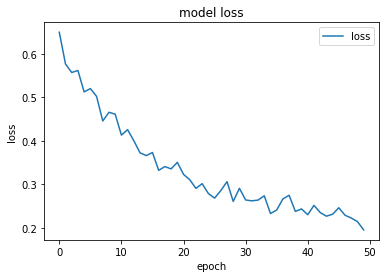

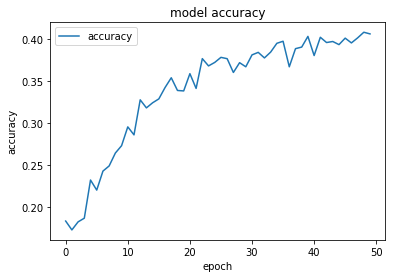

In [10]:
np.random.seed(42)  # set seed for reproducible research

counter = SpeedCounter(data_dir=os.getcwd() + '/data/',
                       video_dir='speed_videos/',
                       annotation_dir='speed_annotations/',
                       lr=1e-3,
                       batch_size=32,
                       n_epochs=50,
                       frame_size=128,
                       window_size=4,
                       use_flow_field=False,
                       grayscale=True,
                       verbose=False)

# uncomment to re-train model
#counter.train()

The accuracy starts to level out around 40% which is at least better than random guessing.

Now that the model is trained, we need some way to evaulate its performance on an entire video instead of just the $k$-frame clips that the model is trained to predict:

In [23]:
from keras.models import model_from_json, Model

def load_model(name):
    model_dir = 'models/'
    with open(model_dir + 'model_architecture.json%s' % name, 'r') as f:
        model = model_from_json(f.read())
    # Load weights into the new model
    model.load_weights(model_dir + 'model_weights%s.h5' % name)
    return model

This code just allows us to load the model from a saved file instead of training it every time.

In [24]:
model = load_model('grayscale')

The function below opens a speed video and splits it into the $k$-frame clips and runs each clip through the model to get a prediction for which frames contain jumps.  The function returns the full one-hot label of the clip and the full prediction vector for each frame from many predictions.

In [49]:
def count_video(video_path, threshold=0.5):
    full_prediction = []
    full_label = []
    video = open_video(data_dir + video_dir + video_path, window_size=window_size)
    label_path = data_dir + annotation_dir + video_path.replace('.mp4', '.npy')
    label = np.load(label_path)
    start_frame = 0
    while start_frame < len(video) - window_size:
        clip = video[start_frame:start_frame + window_size]
        if use_flow_field:
            flow_field = video_to_flow_field(np.uint8(clip))
            label_clip = label[np.where(label < start_frame + window_size - 1)]
            label_clip = label_clip[np.where(label_clip > start_frame)]
            y = np.zeros(window_size - 1)
        else:
            label_clip = label[np.where(label < start_frame + window_size)]
            label_clip = label_clip[np.where(label_clip > start_frame)]
            y = np.zeros(window_size)
        for frame in label_clip:
            y[frame - start_frame] = 1
        full_label.append(y)
        if use_flow_field:
            y_pred = model.predict(np.expand_dims(flow_field, axis=0))
        else:
            y_pred = model.predict(np.expand_dims(clip, axis=0))
        y_pred[y_pred > threshold] = 1
        y_pred[y_pred <= threshold] = 0
        full_prediction.append(y_pred)
        start_frame += window_size
    full_prediction = np.reshape(full_prediction, (-1))
    full_label = np.reshape(full_label, (-1))
    ax = plt.subplot(211)
    ax.imshow(np.dstack([full_prediction] * 50)[0].T, cmap='plasma')
    ax.set_title('Predicted')
    ax.set_yticks([])
    ax = plt.subplot(212)
    ax.imshow(np.dstack([full_label] * 50)[0].T, cmap='plasma')
    ax.set_title('Actual')
    ax.set_yticks([])
    plt.tight_layout(0.8)
    plt.show()
    return full_label, full_prediction
        

We'll test out our model on some of the sample videos:

swe_1.mp4


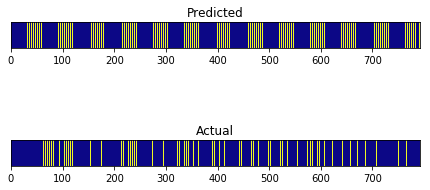

Actual: 124 Predicted: 198
korea_1.mp4


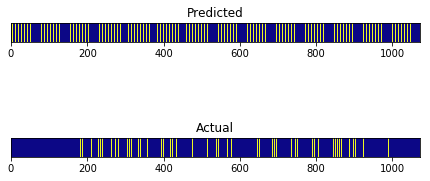

Actual: 136 Predicted: 268
us_5.mp4


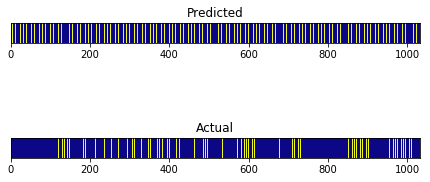

Actual: 145 Predicted: 258
jp_2.mp4


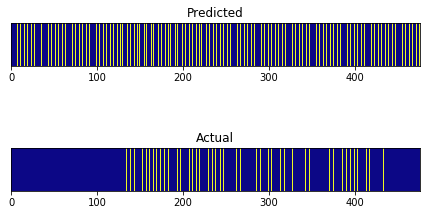

Actual: 50 Predicted: 119
us_4.mp4


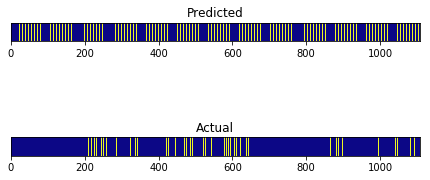

Actual: 126 Predicted: 277


In [50]:
for _ in range(5):
    video_path = np.random.choice(os.listdir(data_dir + video_dir))
    print(video_path)
    label, pred = count_video(video_path)
    print('Actual:', int(np.sum(label)), 'Predicted:', int(np.sum(pred)))

The grayscale model does not appear to perform very well.  The main goal of this project however, is not to develop a perfect model which can achieve 100% accuracy.  With such a small dataset it is unlikely that any model will be able to perform at the level of a trained human judge.  The goal is to understand the inner workings of this particular method and hopefully find a direction to go in once more data can be collected.  One way to do this is to visualize the intermediate activations of each 3D convolutional filter.

The function below creates a new model which outputs the activation of each convolution layer:

In [25]:
def get_model_activations(clip):
    layer_outputs = [layer.output for layer in model.layers if 'activation' in layer.name] 
    activation_model = Model(inputs=model.input, outputs=layer_outputs) 
    activations = activation_model.predict(np.expand_dims(clip, axis=0))
    
    return activations   

Let's try it out on one of the videos from our dataset:

In [31]:
video_path = 'hiro_1.mp4'
print(video_path)
clip, y = get_clip_and_label(video_path)

hiro_1.mp4


In [32]:
interactive_plot = interactive(plot_frame(clip, y), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '360px'
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='360px'))), _dom…

In [54]:
activations = get_model_activations(clip)

<Figure size 576x576 with 0 Axes>

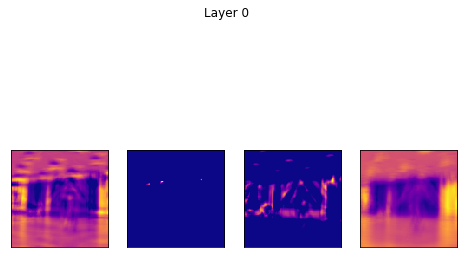

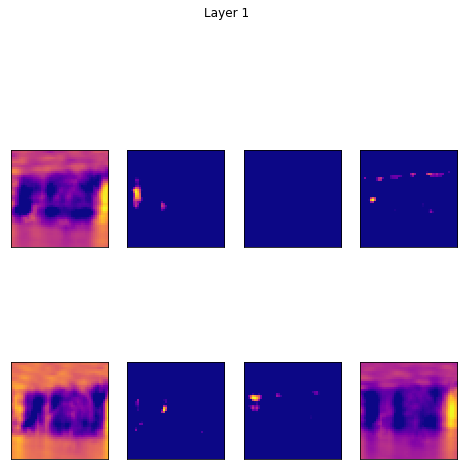

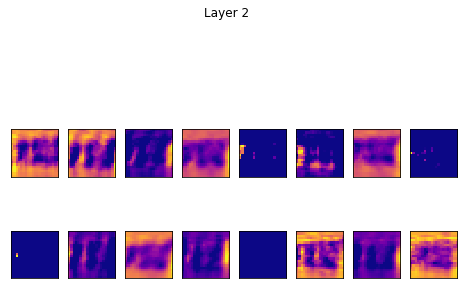

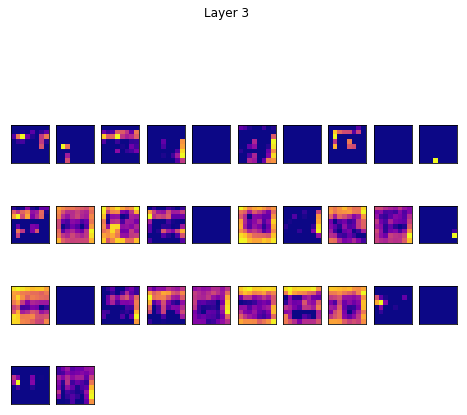

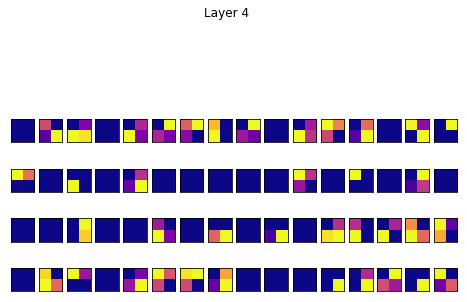

In [55]:
import math

fig = plt.figure(figsize=(8, 8))
for i in range(len(activations)):
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle('Layer %d' % i)
    num_filters = activations[i].shape[-1]
    rows = math.sqrt(num_filters)
    cols = num_filters // rows * 2
    for j in range(activations[i].shape[-1]):
        ax = plt.subplot(rows, cols, j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(activations[i][0, 0, ..., j], cmap='plasma')
    plt.subplots_adjust(top=0.8)
    plt.show()

These plots are very difficult to interpret though.  It doesn't appear that any of the activations are particularly focused on the area of the video containing the jumper until the 3rd layer and at this point our representation has been compressed so much that it's difficult to pull any meaning from these visualizations.  Another way of visualization each filter's activation is to maximize each activation w.r.t the input space by applying gradient ascent at that particular layer:

In [33]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict.keys())

dict_keys(['activation_1', 'batch_normalization_2', 'batch_normalization_3', 'batch_normalization_4', 'conv3d_1', 'video', 'conv3d_3', 'activation_3', 'batch_normalization_5', 'max_pooling3d_4', 'conv3d_2', 'flatten_1', 'activation_5', 'max_pooling3d_2', 'frames', 'batch_normalization_1', 'activation_2', 'max_pooling3d_3', 'conv3d_4', 'conv3d_5', 'max_pooling3d_1', 'activation_4', 'max_pooling3d_5'])


The `layer_dict` above contains each layer of the model.  Keras can compute the gradient at any layer allowing us to find the inputs which maximize the activations of certain filters.

First, since the input to our model is an abstract tensor, we need to be able to convert this into an RGB image:

In [34]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Now we can define a function which takes a layer as input and produces a visualization of the inputs which maximize the filters of that layer:

In [35]:
from keras import backend as K

def plot_conv_layer(model, layer_name, layer_dict, input_video=None, vis_iter=50):
    visualizations = np.array([])
    layer_output = layer_dict[layer_name].output
    input_img = model.input
    rows = 3
    cols = 3
    num_filters = rows * cols
    vis_size = frame_size
    active_layers = 0  # keeps track of number of activated layers currently in the visualization
    filter_index = 0

    while active_layers < num_filters and 'video' not in layer_name:
        if input_video is None:
            if use_flow_field:
                noise_batch = np.random.random((1, window_size - 1, vis_size, vis_size, 2))
            elif grayscale:
                noise_batch = np.random.normal(1, size=(1, window_size, vis_size, vis_size, 1))
            else:
                noise_batch = np.random.normal(1, size=(1, window_size, vis_size, vis_size, 3))
        else:
            noise_batch = input_video
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        try:
            loss = K.mean(layer_output[..., filter_index])
        except Exception as e:
            layer_output = layer_dict[layer_name].output
            filter_index = 0
            pass

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and gradients given the input picture
        iterate = K.function([input_img], [loss, grads])

        filter_index += 1

        step = 1.
        # run gradient ascent for 20 steps
        for i in range(vis_iter):
            loss_value, grads_value = iterate([noise_batch])
            if loss_value == 0:
                break
            noise_batch += grads_value * step
        if loss_value != 0:
            active_layers += 1
            print(active_layers, '/', num_filters)
            visualizations = np.append(visualizations, noise_batch)

    if use_flow_field:
        print(visualizations.shape)
        visualizations = np.reshape(visualizations, (num_filters, 1, window_size - 1, vis_size, vis_size, 2))
    elif grayscale:
        visualizations = np.reshape(visualizations, (num_filters, 1, window_size, vis_size, vis_size, 1))
    else:
        visualizations = np.reshape(visualizations, (num_filters, 1, window_size, vis_size, vis_size, 3))
    frame_offset = 0
    if use_flow_field:
        frame_offset = -1
    
    return visualizations

In [65]:
def plot_filters(visualizations, layer_name, grayscale, use_flow_field, save_filters=False):
    def f(i):
        fig, axes = plt.subplots(3, 3, figsize=(6,6))
        for filter_i in range(visualizations.shape[0]):
            r = int(filter_i // 3)
            c = int(filter_i % 3)
            frame = visualizations[filter_i][0][i]
            save_dir = ''
            if use_flow_field:
                img = flow_to_rgb(np.float32(frame))
                axes[r][c].imshow(img)
                save_dir = 'flow'
            elif grayscale:
                #img = deprocess_image(frame)
                img = np.reshape(frame, (frame_size, frame_size))
                axes[r][c].imshow(img, cmap='plasma')
                save_dir = 'grayscale'
            else:
                img = deprocess_image(frame)
                img = np.reshape(img, (frame_size, frame_size, 3))
                axes[r][c].imshow(img)
                save_dir = 'rgb'
            axes[r][c].set_title(str(filter_i))
            axes[r][c].set_xticks([])
            axes[r][c].set_yticks([])
        fig.suptitle(layer_name)
        plt.tight_layout()
        plt.subplots_adjust(top=0.8)
        if save_filters:
            try:
                os.mkdir('conv_vis')
            except FileExistsError:
                pass
            try:
                os.mkdir('conv_vis/%s' % save_dir)
            except FileExistsError:
                pass
            try:
                os.mkdir('conv_vis/%s/%s' % (save_dir, layer_name))
            except FileExistsError:
                pass
            fig.savefig('conv_vis/' + save_dir + '/%s/%d.png' % (layer_name, i), dpi=250)
    return f

In [37]:
grayscale_filter_images = []
layer_names = []

for layer in layer_dict.keys():
    if 'activation' in layer:
        try:
            layer_names.append(layer)
            visualizations = plot_conv_layer(model, layer, layer_dict, vis_iter=15)
            grayscale_filter_images.append(visualizations)
        except Exception as e:
            pass

1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


I wanted to use interactive plots to display these visualizations but they are very slow and usually do not persist after closing the notebook.  If the figures below are empty I have also saved each frame and display them as animations with interpretations after each of these sections for each model.

In [63]:
save_filters = True  # set to True to save filter visualizations for display later

In [66]:
vis_i = 0
interactive_plot = interactive(plot_filters(grayscale_filter_images[vis_i], layer_names[vis_i], grayscale=True, use_flow_field=False, save_filters=save_filters), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [67]:
interactive_plot = interactive(plot_filters(grayscale_filter_images[vis_i], layer_names[vis_i], grayscale=True, use_flow_field=False, save_filters=save_filters), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [68]:
interactive_plot = interactive(plot_filters(grayscale_filter_images[vis_i], layer_names[vis_i], grayscale=True, use_flow_field=False, save_filters=save_filters), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [69]:
interactive_plot = interactive(plot_filters(grayscale_filter_images[vis_i], layer_names[vis_i], grayscale=True, use_flow_field=False, save_filters=save_filters), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [70]:
interactive_plot = interactive(plot_filters(grayscale_filter_images[vis_i], layer_names[vis_i], grayscale=True, use_flow_field=False, save_filters=save_filters), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

A good way to visualize the motion that each filter has captured is to play them back as animations.  For this I am displaying each 'frame' of the filter at 15fps and looping forward and backward:

In [2]:
%%HTML
<img src="figures/filters/grayscale/activation_1.gif" width="360" height="360" /> 

In [3]:
%%HTML
<img src="figures/filters/grayscale/activation_2.gif" width="360" height="360" /> 

In [4]:
%%HTML
<img src="figures/filters/grayscale/activation_3.gif" width="360" height="360" /> 

In [5]:
%%HTML
<img src="figures/filters/grayscale/activation_4.gif" width="360" height="360" /> 

In [6]:
%%HTML
<img src="figures/filters/grayscale/activation_5.gif" width="360" height="360" /> 

It seems that the first couple layers are trying to pick up on large scale motion in the video such as the camera moving.  Deeper layers, by my own interpretation, start to resemble feet passing by each other from different angles indicating that the model did learn an inner representation of what a jump looks like within a small window of frames.

Now we will try to train a model by first converting each input video into a vector field representing dense optical flow using an `OpenCV` implementation of Gunner Farneback's algorithm (https://docs.opencv.org/3.1.0/d7/d8b/tutorial_py_lucas_kanade.html)

In [90]:
grayscale = False
use_flow_field = True
window_size = 5

Total Frames: 14415
Total Samples: 2883
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
video (InputLayer)           (None, 4, 128, 128, 2)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 3, 113, 113, 4)    4100      
_________________________________________________________________
batch_normalization_21 (Batc (None, 3, 113, 113, 4)    16        
_________________________________________________________________
activation_21 (Activation)   (None, 3, 113, 113, 4)    0         
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 3, 56, 56, 4)      0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 2, 49, 49, 8)      4104      
_________________________________________________________________
batch_normalization

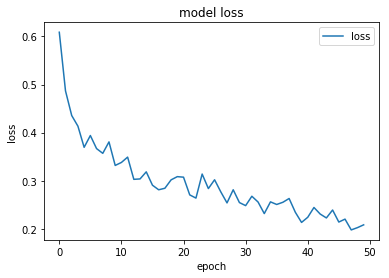

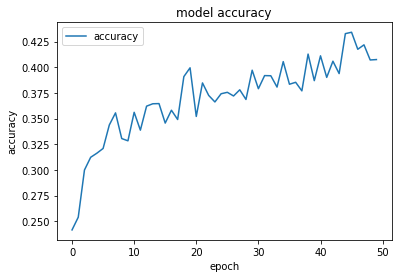

In [86]:
np.random.seed(42)

counter = SpeedCounter(data_dir=os.getcwd() + '/data/',
                       video_dir='speed_videos/',
                       annotation_dir='speed_annotations/',
                       lr=1e-3,
                       batch_size=32,
                       n_epochs=50,
                       frame_size=128,
                       window_size=window_size,
                       use_flow_field=use_flow_field,
                       grayscale=grayscale,
                       verbose=False)

# uncomment to re-train model
#counter.train()

Similarly, the model accuracy does not increase much beyond 40%

In [91]:
model = load_model('flow')

us_3.mp4


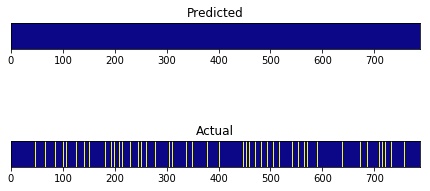

Actual: 77 Predicted: 0
us_1.mp4


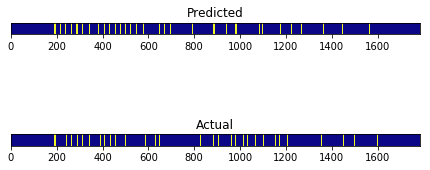

Actual: 148 Predicted: 137
us_4.mp4


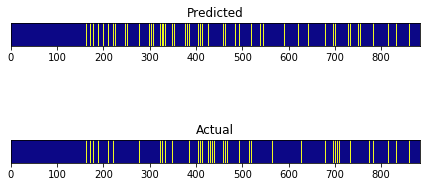

Actual: 109 Predicted: 119
jp_2.mp4


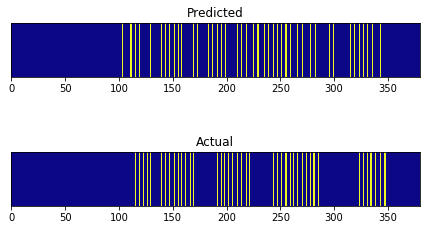

Actual: 42 Predicted: 43
jp_1.mp4


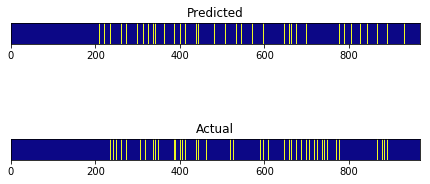

Actual: 105 Predicted: 89


In [88]:
for _ in range(5):
    video_path = np.random.choice(os.listdir(data_dir + video_dir))
    print(video_path)
    label, pred = count_video(video_path, threshold=0.8)
    print('Actual:', int(np.sum(label)), 'Predicted:', int(np.sum(pred)))

Performance across full videos however has significantly improved compared to the grayscale model.  This is likely because the accuracy measures if the model got the frame prediction exactly right, however to accurately count a full video we only have to classify each $k$-frame window as having *a* jump.  So even if the model is off by a frame or two, it is technically a correct prediction.

In [92]:
video_path = 'hiro_1.mp4'
print(video_path)
clip, y = get_clip_and_label(video_path)

hiro_1.mp4


In [93]:
interactive_plot = interactive(plot_frame(clip, y), i=(0, window_size - 2))
output = interactive_plot.children[-1]
output.layout.height = '360px'
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='360px'))), _dom…

We can visualize this dense optical flow by converting the magnitude to intensity and direction to color values.  Interestingly, the densest motion during the spike of the jump is around the jumper's wrists.

In [91]:
activations = get_model_activations(clip)

One main downside to this method is that beyond the first layer, all activations only have 1 'frame' (i.e their 3rd time axis is flattened after the first two convolutions)

<Figure size 576x576 with 0 Axes>

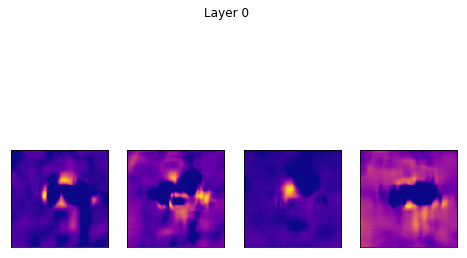

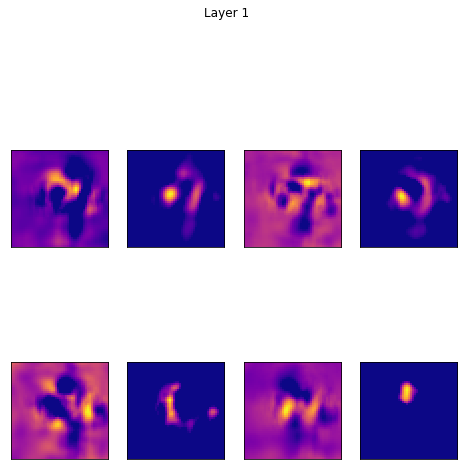

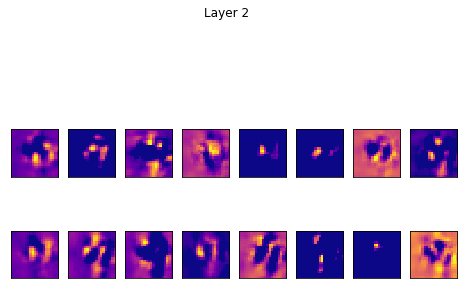

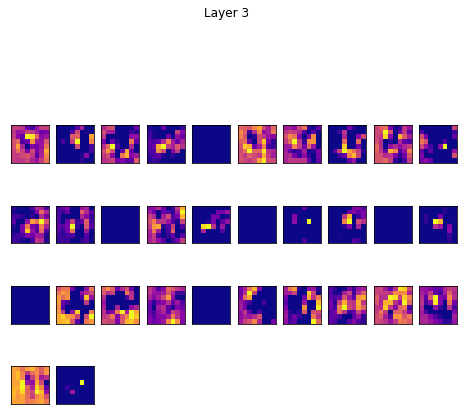

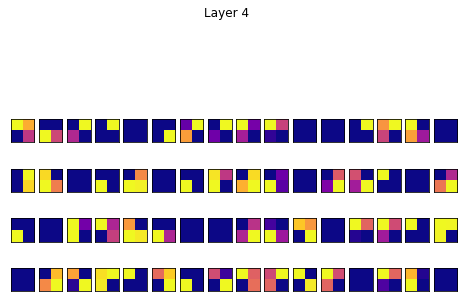

In [92]:
import math

fig = plt.figure(figsize=(8, 8))
for i in range(len(activations)):
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle('Layer %d' % i)
    num_filters = activations[i].shape[-1]
    rows = math.sqrt(num_filters)
    cols = num_filters // rows * 2
    for j in range(activations[i].shape[-1]):
        ax = plt.subplot(rows, cols, j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(activations[i][0, 0, ..., j], cmap='plasma')
    plt.subplots_adjust(top=0.8)
    plt.show()

Compared to the grayscale model's activations, these seem a little more interpretable.  The main areas of activation seem to be where the motion is densest such as the arms and legs.  This is interesting since human judges exclusively count based on the jumper's feet, but the wrists and rope motion can also give a lot of useful information which it appears the model is picking up on.

Let's visualize the input space maximized w.r.t the layer activations:

In [94]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict.keys())

dict_keys(['batch_normalization_22', 'max_pooling3d_23', 'video', 'flatten_5', 'conv3d_24', 'max_pooling3d_22', 'max_pooling3d_21', 'activation_22', 'activation_25', 'frames', 'conv3d_25', 'conv3d_21', 'activation_21', 'activation_23', 'max_pooling3d_25', 'activation_24', 'batch_normalization_23', 'batch_normalization_25', 'conv3d_22', 'batch_normalization_24', 'batch_normalization_21', 'conv3d_23', 'max_pooling3d_24'])


In [95]:
flow_filter_images = []
layer_names = []

for layer in layer_dict.keys():
    if 'activation' in layer:
        try:
            layer_names.append(layer)
            visualizations = plot_conv_layer(model, layer, layer_dict, vis_iter=15)
            flow_filter_images.append(visualizations)
        except Exception as e:
            print(e)
            pass

1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
(1179648,)
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
(1179648,)
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
(1179648,)
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
(1179648,)
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
(1179648,)


In [97]:
vis_i = 0
interactive_plot = interactive(plot_filters(flow_filter_images[vis_i], layer_names[vis_i], grayscale, use_flow_field, save_filters=save_filters), i=(0, window_size - 2))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [98]:
interactive_plot = interactive(plot_filters(flow_filter_images[vis_i], layer_names[vis_i], grayscale, use_flow_field, save_filters=save_filters), i=(0, window_size - 2))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [99]:
interactive_plot = interactive(plot_filters(flow_filter_images[vis_i], layer_names[vis_i], grayscale, use_flow_field, save_filters=save_filters), i=(0, window_size - 2))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [100]:
interactive_plot = interactive(plot_filters(flow_filter_images[vis_i], layer_names[vis_i], grayscale, use_flow_field, save_filters=save_filters), i=(0, window_size - 2))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [101]:
interactive_plot = interactive(plot_filters(flow_filter_images[vis_i], layer_names[vis_i], grayscale, use_flow_field, save_filters=save_filters), i=(0, window_size - 2))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [7]:
%%HTML
<img src="figures/filters/flow/activation_21.gif" width="360" height="360" /> 

In [8]:
%%HTML
<img src="figures/filters/flow/activation_22.gif" width="360" height="360" /> 

In [9]:
%%HTML
<img src="figures/filters/flow/activation_23.gif" width="360" height="360" /> 

In [10]:
%%HTML
<img src="figures/filters/flow/activation_24.gif" width="360" height="360" /> 

In [11]:
%%HTML
<img src="figures/filters/flow/activation_25.gif" width="360" height="360" /> 

These are much harder to interpret than the grayscale model visualizations.  The first layer has abstract patterns similar to the first layer of the grayscale model but beyond that these do not appear to resemble a human-interpretable representation of a jump, even though the model is able to out-perform the grayscale model.

Finally, let's try to build a model that sees the raw video in color:

In [107]:
use_flow_field = False
grayscale = False
window_size = 4

Total Frames: 14415
Total Samples: 3603
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
video (InputLayer)           (None, 4, 128, 128, 3)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 3, 113, 113, 4)    6148      
_________________________________________________________________
batch_normalization_26 (Batc (None, 3, 113, 113, 4)    16        
_________________________________________________________________
activation_26 (Activation)   (None, 3, 113, 113, 4)    0         
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 3, 56, 56, 4)      0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 2, 49, 49, 8)      4104      
_________________________________________________________________
batch_normalizatio

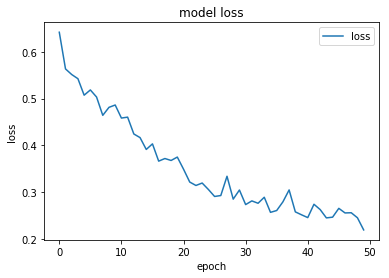

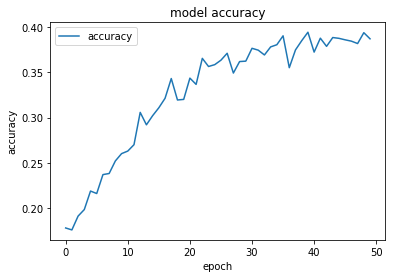

In [101]:
np.random.seed(42)

counter = SpeedCounter(data_dir=os.getcwd() + '/data/',
                       video_dir='speed_videos/',
                       annotation_dir='speed_annotations/',
                       lr=1e-3,
                       batch_size=32,
                       n_epochs=50,
                       frame_size=128,
                       window_size=window_size,
                       use_flow_field=False,
                       grayscale=False,
                       verbose=False)

# uncomment to re-train model
#counter.train()

In [108]:
model = load_model('RGB')

The function below opens a speed video and splits it into the $k$-frame clips and runs each clip through the model to get a prediction for which frames contain jumps.  The function returns the full one-hot label of the clip and the full prediction vector for each frame from many predictions.

swe_1.mp4


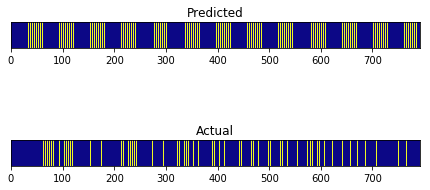

Actual: 124 Predicted: 197
korea_1.mp4


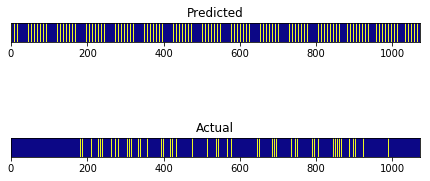

Actual: 136 Predicted: 268
hiro_2.mp4


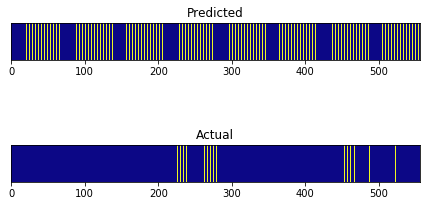

Actual: 28 Predicted: 139
china_1.mp4


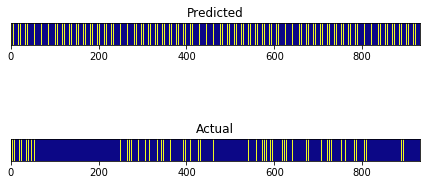

Actual: 138 Predicted: 232
hiro_2.mp4


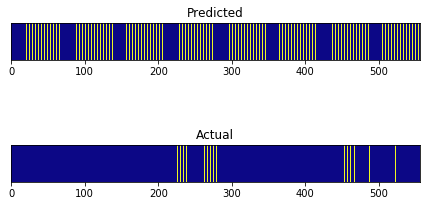

Actual: 28 Predicted: 139


In [105]:
for _ in range(5):
    video_path = np.random.choice(os.listdir(data_dir + video_dir))
    print(video_path)
    label, pred = count_video(video_path, threshold=0.8)
    print('Actual:', int(np.sum(label)), 'Predicted:', int(np.sum(pred)))

The main goal of this project however, is not to develop a perfect model which can achieve 100% accuracy.  The goal is to understand the inner workings of this particular method.  One way to do this is to visualize the intermediate activations of each 3D convolutional filter.

The function below creates a new model which outputs the activation of each convolution layer:

Let's try it out on one of the videos from our dataset:

In [114]:
video_path = 'hiro_1.mp4'
print(video_path)
clip, y = get_clip_and_label(video_path)

hiro_1.mp4


In [115]:
interactive_plot = interactive(plot_frame(clip, y), i=(0, window_size - 2))
output = interactive_plot.children[-1]
output.layout.height = '360px'
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=2), Output(layout=Layout(height='360px'))), _dom…

In [108]:
activations = get_model_activations(clip)

One main downside to this method is that beyond the first layer, all activations only have 1 'frame' (i.e their 3rd time axis is flattened after the first two convolutions)

<Figure size 576x576 with 0 Axes>

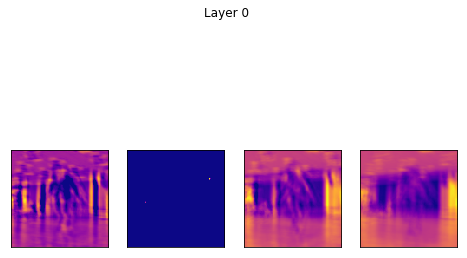

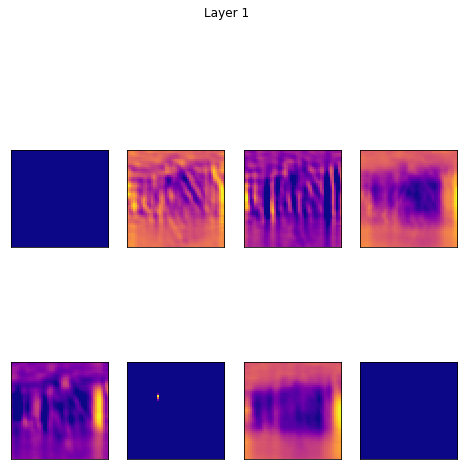

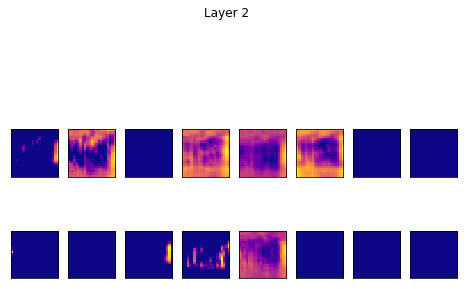

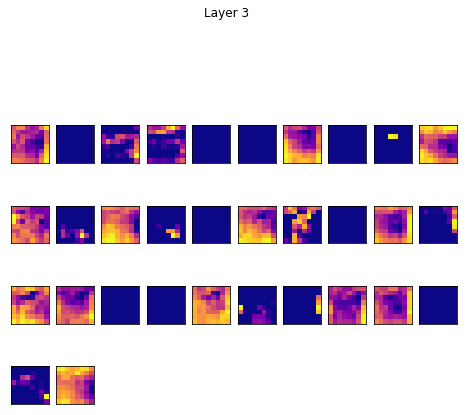

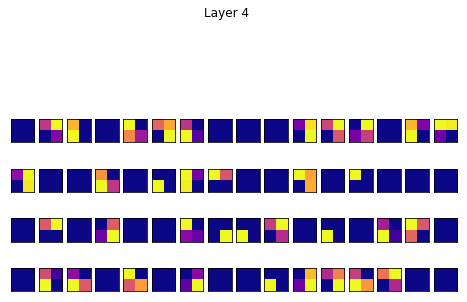

In [109]:
import math

fig = plt.figure(figsize=(8, 8))
for i in range(len(activations)):
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle('Layer %d' % i)
    num_filters = activations[i].shape[-1]
    rows = math.sqrt(num_filters)
    cols = num_filters // rows * 2
    for j in range(activations[i].shape[-1]):
        ax = plt.subplot(rows, cols, j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(activations[i][0, 0, ..., j], cmap='plasma')
    plt.subplots_adjust(top=0.8)
    plt.show()

These activations look alsmost identical to the grayscale model activation visualizations.

In [116]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict.keys())

dict_keys(['conv3d_30', 'batch_normalization_30', 'max_pooling3d_27', 'activation_30', 'activation_28', 'video', 'max_pooling3d_30', 'max_pooling3d_29', 'max_pooling3d_26', 'flatten_6', 'max_pooling3d_28', 'batch_normalization_27', 'activation_29', 'activation_26', 'batch_normalization_29', 'conv3d_29', 'batch_normalization_26', 'frames', 'batch_normalization_28', 'conv3d_27', 'activation_27', 'conv3d_26', 'conv3d_28'])


In [117]:
rgb_filter_images = []
layer_names = []

for layer in layer_dict.keys():
    if 'activation' in layer:
        try:
            layer_names.append(layer)
            visualizations = plot_conv_layer(model, layer, layer_dict, vis_iter=15)
            rgb_filter_images.append(visualizations)
        except Exception as e:
            print(e)
            pass

1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


In [120]:
vis_i = 0
interactive_plot = interactive(plot_filters(rgb_filter_images[vis_i], layer_names[vis_i], grayscale, use_flow_field, save_filters=save_filters), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [121]:
interactive_plot = interactive(plot_filters(rgb_filter_images[vis_i], layer_names[vis_i], grayscale, use_flow_field, save_filters=save_filters), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [122]:
interactive_plot = interactive(plot_filters(rgb_filter_images[vis_i], layer_names[vis_i], grayscale, use_flow_field, save_filters=save_filters), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [123]:
interactive_plot = interactive(plot_filters(rgb_filter_images[vis_i], layer_names[vis_i], grayscale, use_flow_field, save_filters=save_filters), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [124]:
interactive_plot = interactive(plot_filters(rgb_filter_images[vis_i], layer_names[vis_i], grayscale, use_flow_field, save_filters=save_filters), i=(0, window_size - 1))
output = interactive_plot.children[-1]
output.layout.height = '480px'
vis_i += 1
interactive_plot

interactive(children=(IntSlider(value=1, description='i', max=3), Output(layout=Layout(height='480px'))), _dom…

In [12]:
%%HTML
<img src="figures/filters/rgb/activation_26.gif" width="360" height="360" /> 

In [13]:
%%HTML
<img src="figures/filters/rgb/activation_27.gif" width="360" height="360" /> 

In [14]:
%%HTML
<img src="figures/filters/rgb/activation_28.gif" width="360" height="360" /> 

In [15]:
%%HTML
<img src="figures/filters/rgb/activation_29.gif" width="360" height="360" /> 

In [16]:
%%HTML
<img src="figures/filters/rgb/activation_30.gif" width="360" height="360" /> 

Once again, these visualizations looks very similar to the grayscale visualizations except in the deeper layers.  The model seemd to be picking up on the rapidly changing motion that occurs at the jumper's feet during a jump, but this is not as pronounced as in the grayscale model.  Based on the lack on increased performance from the grayscale model to this, I think it is sufficient to only use grayscale values and not the full RGB spectrum of the video.

Overall, this project was a great dive into the inner workings of neural networks and how to approach certain vision problems from a computational perspective.  Even though the models are not yet at the level of human judges, I think in the future it will be possible to collect more data a train a more general model. Until then, we can use this smaller dataset and model to learn about which features give rise to better performance and how to better adjust out model architecture and training.